In [2]:
import pandas as pd
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier, plot_tree
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import json
import re
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score

- split the data into training and testing
- treat any null/missing values
- use one-hot encoding to convert categorical columns into k-category columns. Apply the one-hot encoder to the categorical columns of training and then to the testing
- find the cost-complexity parameter to prune the decision tree in order to prevent overfitting
- Analyse the decision tree.
- https://towardsdatascience.com/the-easiest-way-to-interpret-clustering-result-8137e488a127

# Unscaled Dataset

In [3]:
# change the path as necessary
df_unscaled = pd.read_csv(r'../data/k_prototypes_unscaled_rules/kprototypes_labeled_unscaled.csv')
df_unscaled.rename(columns={'Unnamed: 0': 'DR Number'}, inplace=True)
df_unscaled

,DR Number,Area ID,Premise Description,month,day,year,hour,Day Category,Area Name,lat,long,label
0,100100007,1,STREET,11,8,2010,22,night,Central,34.0395,-118.2656,0
1,100100767,1,STREET,3,31,2010,4,early_morning,Central,34.0695,-118.2324,0
2,100100831,1,STREET,4,18,2010,1,early_morning,Central,34.0424,-118.2718,0
3,100101004,1,STREET,6,5,2010,20,night,Central,34.0344,-118.2714,0
4,100101322,1,STREET,8,7,2010,16,evening,Central,34.0637,-118.2361,0
...,...,...,...,...,...,...,...,...,...,...,...,...
570367,222104843,21,STREET,1,26,2022,19,night,Topanga,34.1857,-118.5710,0
570368,222104874,21,STREET,1,24,2022,15,afternoon,Topanga,34.1938,-118.6059,2
570369,222104886,21,STREET,1,24,2022,17,evening,Topanga,34.1740,-118.5888,2
570370,222104962,21,STREET,1,28,2022,19,night,Topanga,34.1624,-118.6285,0


- Split the data into training and testing (80:20)
- Split the training into multiple dataframes to test each cluster as binary classification
- Visualize and interpret clusters
- Train final decision tree model on the entire training set and use the test set to ensure model doesn't overfit and whether decisions made are valid.

In [4]:
#train, test = train_test_split(df_unscaled, test_size=0.10, random_state=42)
# train = train.fillna("Unknown")
# test = test.fillna("Unknown")
# categorical_cols = ['Premise Description', 'Day Category', 'Area Name', 'month', 'day', 'hour']

# print('Unique Items in each categorical column')

    

# def preprocess(train, test):
#     categorical_cols = ['Premise Description', 'Day Category', 'Area Name', 'month', 'day', 'hour']
#     enc = OneHotEncoder(handle_unknown='ignore')
#     X_train = pd.DataFrame(enc.fit_transform(train[categorical_cols]).toarray())
#     X_test = pd.DataFrame(enc.transform(test[categorical_cols]).toarray())

#     X_train.columns = list(enc.get_feature_names_out(categorical_cols))
#     X_test.columns = list(enc.get_feature_names_out(categorical_cols)) 

#     X_train['latitude'] = train['lat']
#     X_train['longitude'] = train['long']
#     X_test['latitude'] = test['lat']
#     X_test['longitude'] = test['long']

#     y_train = train['label']
#     y_test = test['label']

#     return X_train, X_test, y_train, y_test

In [4]:
df_unscaled.label.value_counts()

0    213322
2    180286
1    176764
Name: label, dtype: int64

In [5]:
y_0 = df_unscaled['label'].apply(lambda x: 1 if x==0 else 0)
y_1 = df_unscaled['label'].apply(lambda x: 1 if x==1 else 0)
y_2 = df_unscaled['label'].apply(lambda x: 1 if x==2 else 0)

print(y_0.value_counts())
print('\n')
print(y_1.value_counts())
print('\n')
print(y_2.value_counts())

0    357050
1    213322
Name: label, dtype: int64


0    393608
1    176764
Name: label, dtype: int64


0    390086
1    180286
Name: label, dtype: int64


In [6]:
df_unscaled = df_unscaled[['Area Name', 'Premise Description', 'month', 'day', 'hour', 'Day Category', 'lat', 'long']]
df_unscaled

,Area Name,Premise Description,month,day,hour,Day Category,lat,long
0,Central,STREET,11,8,22,night,34.0395,-118.2656
1,Central,STREET,3,31,4,early_morning,34.0695,-118.2324
2,Central,STREET,4,18,1,early_morning,34.0424,-118.2718
3,Central,STREET,6,5,20,night,34.0344,-118.2714
4,Central,STREET,8,7,16,evening,34.0637,-118.2361
...,...,...,...,...,...,...,...,...
570367,Topanga,STREET,1,26,19,night,34.1857,-118.5710
570368,Topanga,STREET,1,24,15,afternoon,34.1938,-118.6059
570369,Topanga,STREET,1,24,17,evening,34.1740,-118.5888
570370,Topanga,STREET,1,28,19,night,34.1624,-118.6285


In [7]:
df_unscaled.iloc[:, -2:].describe()

,lat,long
count,570372.000000,570372.000000
mean,34.080996,-118.362411
std,0.112556,0.137284
min,33.342700,-119.180595
25%,34.018100,-118.440000
50%,34.063800,-118.335800
75%,34.175800,-118.281500
max,42.337041,-71.209221


In [8]:
categorical_cols = list(df_unscaled.columns[:-2])
numerical_cols = list(df_unscaled.columns[-2:])

enc = OneHotEncoder(handle_unknown='ignore')
df_1 = pd.DataFrame(enc.fit_transform(df_unscaled[categorical_cols]).toarray())
df_1.columns = list(enc.get_feature_names_out(categorical_cols))
X = pd.concat((df_1, df_unscaled[numerical_cols]), axis=1)

X

,Area Name_77th Street,Area Name_Central,Area Name_Devonshire,Area Name_Foothill,Area Name_Harbor,Area Name_Hollenbeck,Area Name_Hollywood,Area Name_Mission,Area Name_N Hollywood,Area Name_Newton,...,hour_21,hour_22,hour_23,Day Category_afternoon,Day Category_early_morning,Day Category_evening,Day Category_morning,Day Category_night,lat,long
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0395,-118.2656
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34.0695,-118.2324
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34.0424,-118.2718
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34.0344,-118.2714
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,34.0637,-118.2361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34.1857,-118.5710
570368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.1938,-118.6059
570369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,34.1740,-118.5888
570370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34.1624,-118.6285


In [9]:
sum = 0
for col in categorical_cols:
    sum += df_unscaled[col].nunique()
    print(col, df_unscaled[col].nunique())

print(sum)

Area Name 21
Premise Description 119
month 12
day 31
hour 23
Day Category 5
211


<hr>

In [10]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict
def cluster_report(num, data: pd.DataFrame, clusters, min_samples_leaf=1, pruning_level=0.05):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
          # rule 1: proportion of instance that belong to cluster x
          # rule 0: The rules...
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
    
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    report_sorted = report_df.sort_values(by='class_name')[['class_name', 'rule_list']]
    class_rules = report_sorted.iloc[1,1].split('\n\n')

    with open(f'../data/k_prototypes_unscaled_rules/rule_cluster{num}', 'w') as f:
      
      f.write(f'Class rules for cluster {num}')
      f.write('\n')
      f.write('\n')
      for rule in class_rules:
        f.write(rule)
        f.write('\n')

<h2>Cluster 0</h2>

In [68]:
# Cost Complexity Pruning for finding optimal parameters

In [69]:
parameters_0 = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions= {
        "ccp_alpha":np.arange(0, 0.21, 0.01),
        "min_samples_leaf": np.arange(1,10)
    },
    cv=5
)


parameters_0.fit(X, y_0)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [70]:
print(parameters_0.best_params_)

{'min_samples_leaf': 6, 'ccp_alpha': 0.01}


[Text(0.6, 0.9285714285714286, 'Day Category_night <= 0.5\ngini = 0.468\nsamples = 570372\nvalue = [357050, 213322]\nclass = 0'),
 Text(0.4, 0.7857142857142857, 'Area Name_77th Street <= 0.5\ngini = 0.375\nsamples = 447845\nvalue = [335732, 112113]\nclass = 0'),
 Text(0.3, 0.6428571428571429, 'long <= -118.319\ngini = 0.32\nsamples = 418804\nvalue = [334973, 83831]\nclass = 0'),
 Text(0.2, 0.5, 'gini = 0.151\nsamples = 242331\nvalue = [222389, 19942]\nclass = 0'),
 Text(0.4, 0.5, 'Day Category_evening <= 0.5\ngini = 0.462\nsamples = 176473\nvalue = [112584, 63889]\nclass = 0'),
 Text(0.3, 0.35714285714285715, 'Day Category_early_morning <= 0.5\ngini = 0.375\nsamples = 132248\nvalue = [99230, 33018]\nclass = 0'),
 Text(0.2, 0.21428571428571427, 'month_11 <= 0.5\ngini = 0.236\nsamples = 105501\nvalue = [91045, 14456]\nclass = 0'),
 Text(0.1, 0.07142857142857142, 'gini = 0.158\nsamples = 96782\nvalue = [88434, 8348]\nclass = 0'),
 Text(0.3, 0.07142857142857142, 'gini = 0.42\nsamples = 871

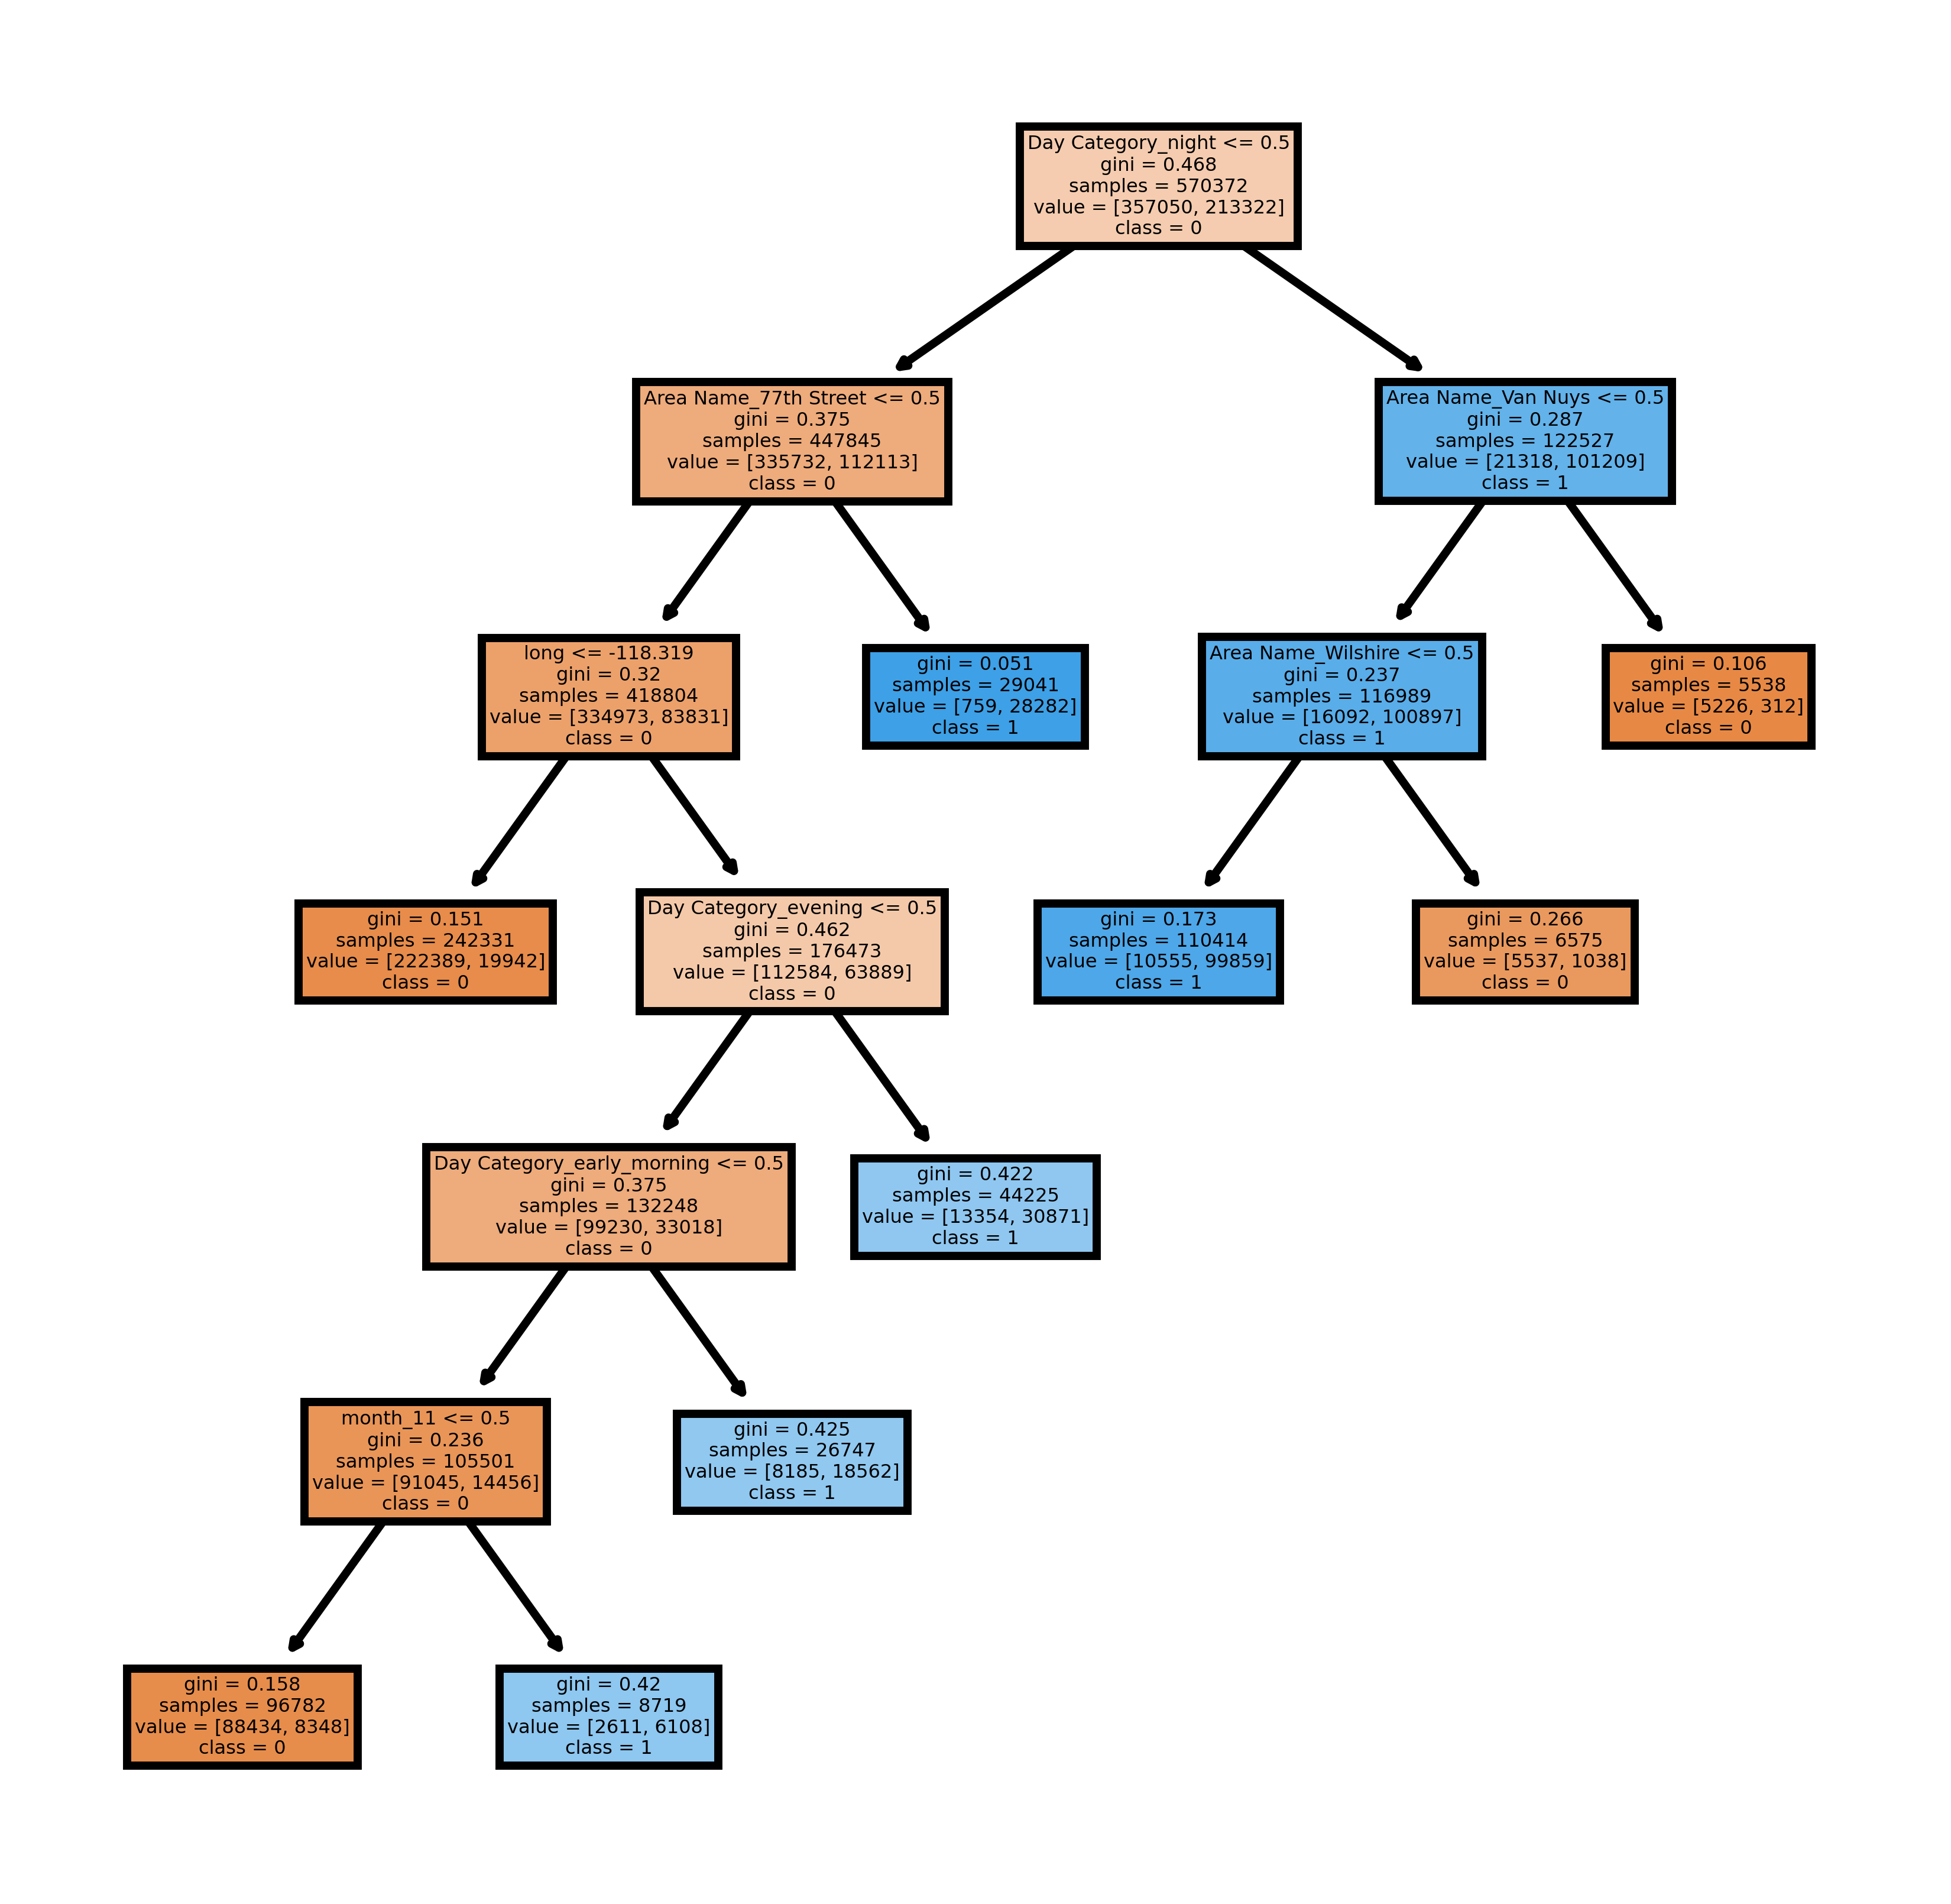

In [83]:
model_0 = parameters_0.best_estimator_ 

plt.figure(figsize=(4,4), dpi=1000)
plot_tree(
    model_0, 
    feature_names=list(X.columns),
    class_names=[str(class_) for class_ in list(model_0.classes_)],
    filled=True
)

- 'feature_x > 0.5': This means feature = x
- 'feature_x <= 0.5': This means feature != x

In [85]:
# Cluster 0 evaluation
cluster_report(0, X, y_0, min_samples_leaf=6, pruning_level=0.01)

<h3>Cluster 1</h3>

In [73]:
parameters_1 = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions= {
        "ccp_alpha":np.arange(0, 0.21, 0.01),
        "min_samples_leaf": np.arange(1,10)
    },
    cv=5
)


parameters_1.fit(X, y_1)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [74]:
print(parameters_1.best_params_)

{'min_samples_leaf': 9, 'ccp_alpha': 0.01}


In [88]:
# Cluster 1 evaluation
cluster_report(1, X, y_1, min_samples_leaf=9, pruning_level=0.01)

[Text(0.5555555555555556, 0.875, 'Day Category_morning <= 0.5\ngini = 0.428\nsamples = 570372\nvalue = [393608, 176764]\nclass = 0'),
 Text(0.3333333333333333, 0.625, 'Area Name_Wilshire <= 0.5\ngini = 0.267\nsamples = 431956\nvalue = [363480, 68476]\nclass = 0'),
 Text(0.2222222222222222, 0.375, 'month_2 <= 0.5\ngini = 0.2\nsamples = 407998\nvalue = [362017, 45981]\nclass = 0'),
 Text(0.1111111111111111, 0.125, 'gini = 0.144\nsamples = 376268\nvalue = [346937, 29331]\nclass = 0'),
 Text(0.3333333333333333, 0.125, 'gini = 0.499\nsamples = 31730\nvalue = [15080, 16650]\nclass = 1'),
 Text(0.4444444444444444, 0.375, 'gini = 0.115\nsamples = 23958\nvalue = [1463, 22495]\nclass = 1'),
 Text(0.7777777777777778, 0.625, 'Area Name_77th Street <= 0.5\ngini = 0.341\nsamples = 138416\nvalue = [30128, 108288]\nclass = 1'),
 Text(0.6666666666666666, 0.375, 'Area Name_Van Nuys <= 0.5\ngini = 0.281\nsamples = 129974\nvalue = [22005, 107969]\nclass = 1'),
 Text(0.5555555555555556, 0.125, 'gini = 0.21

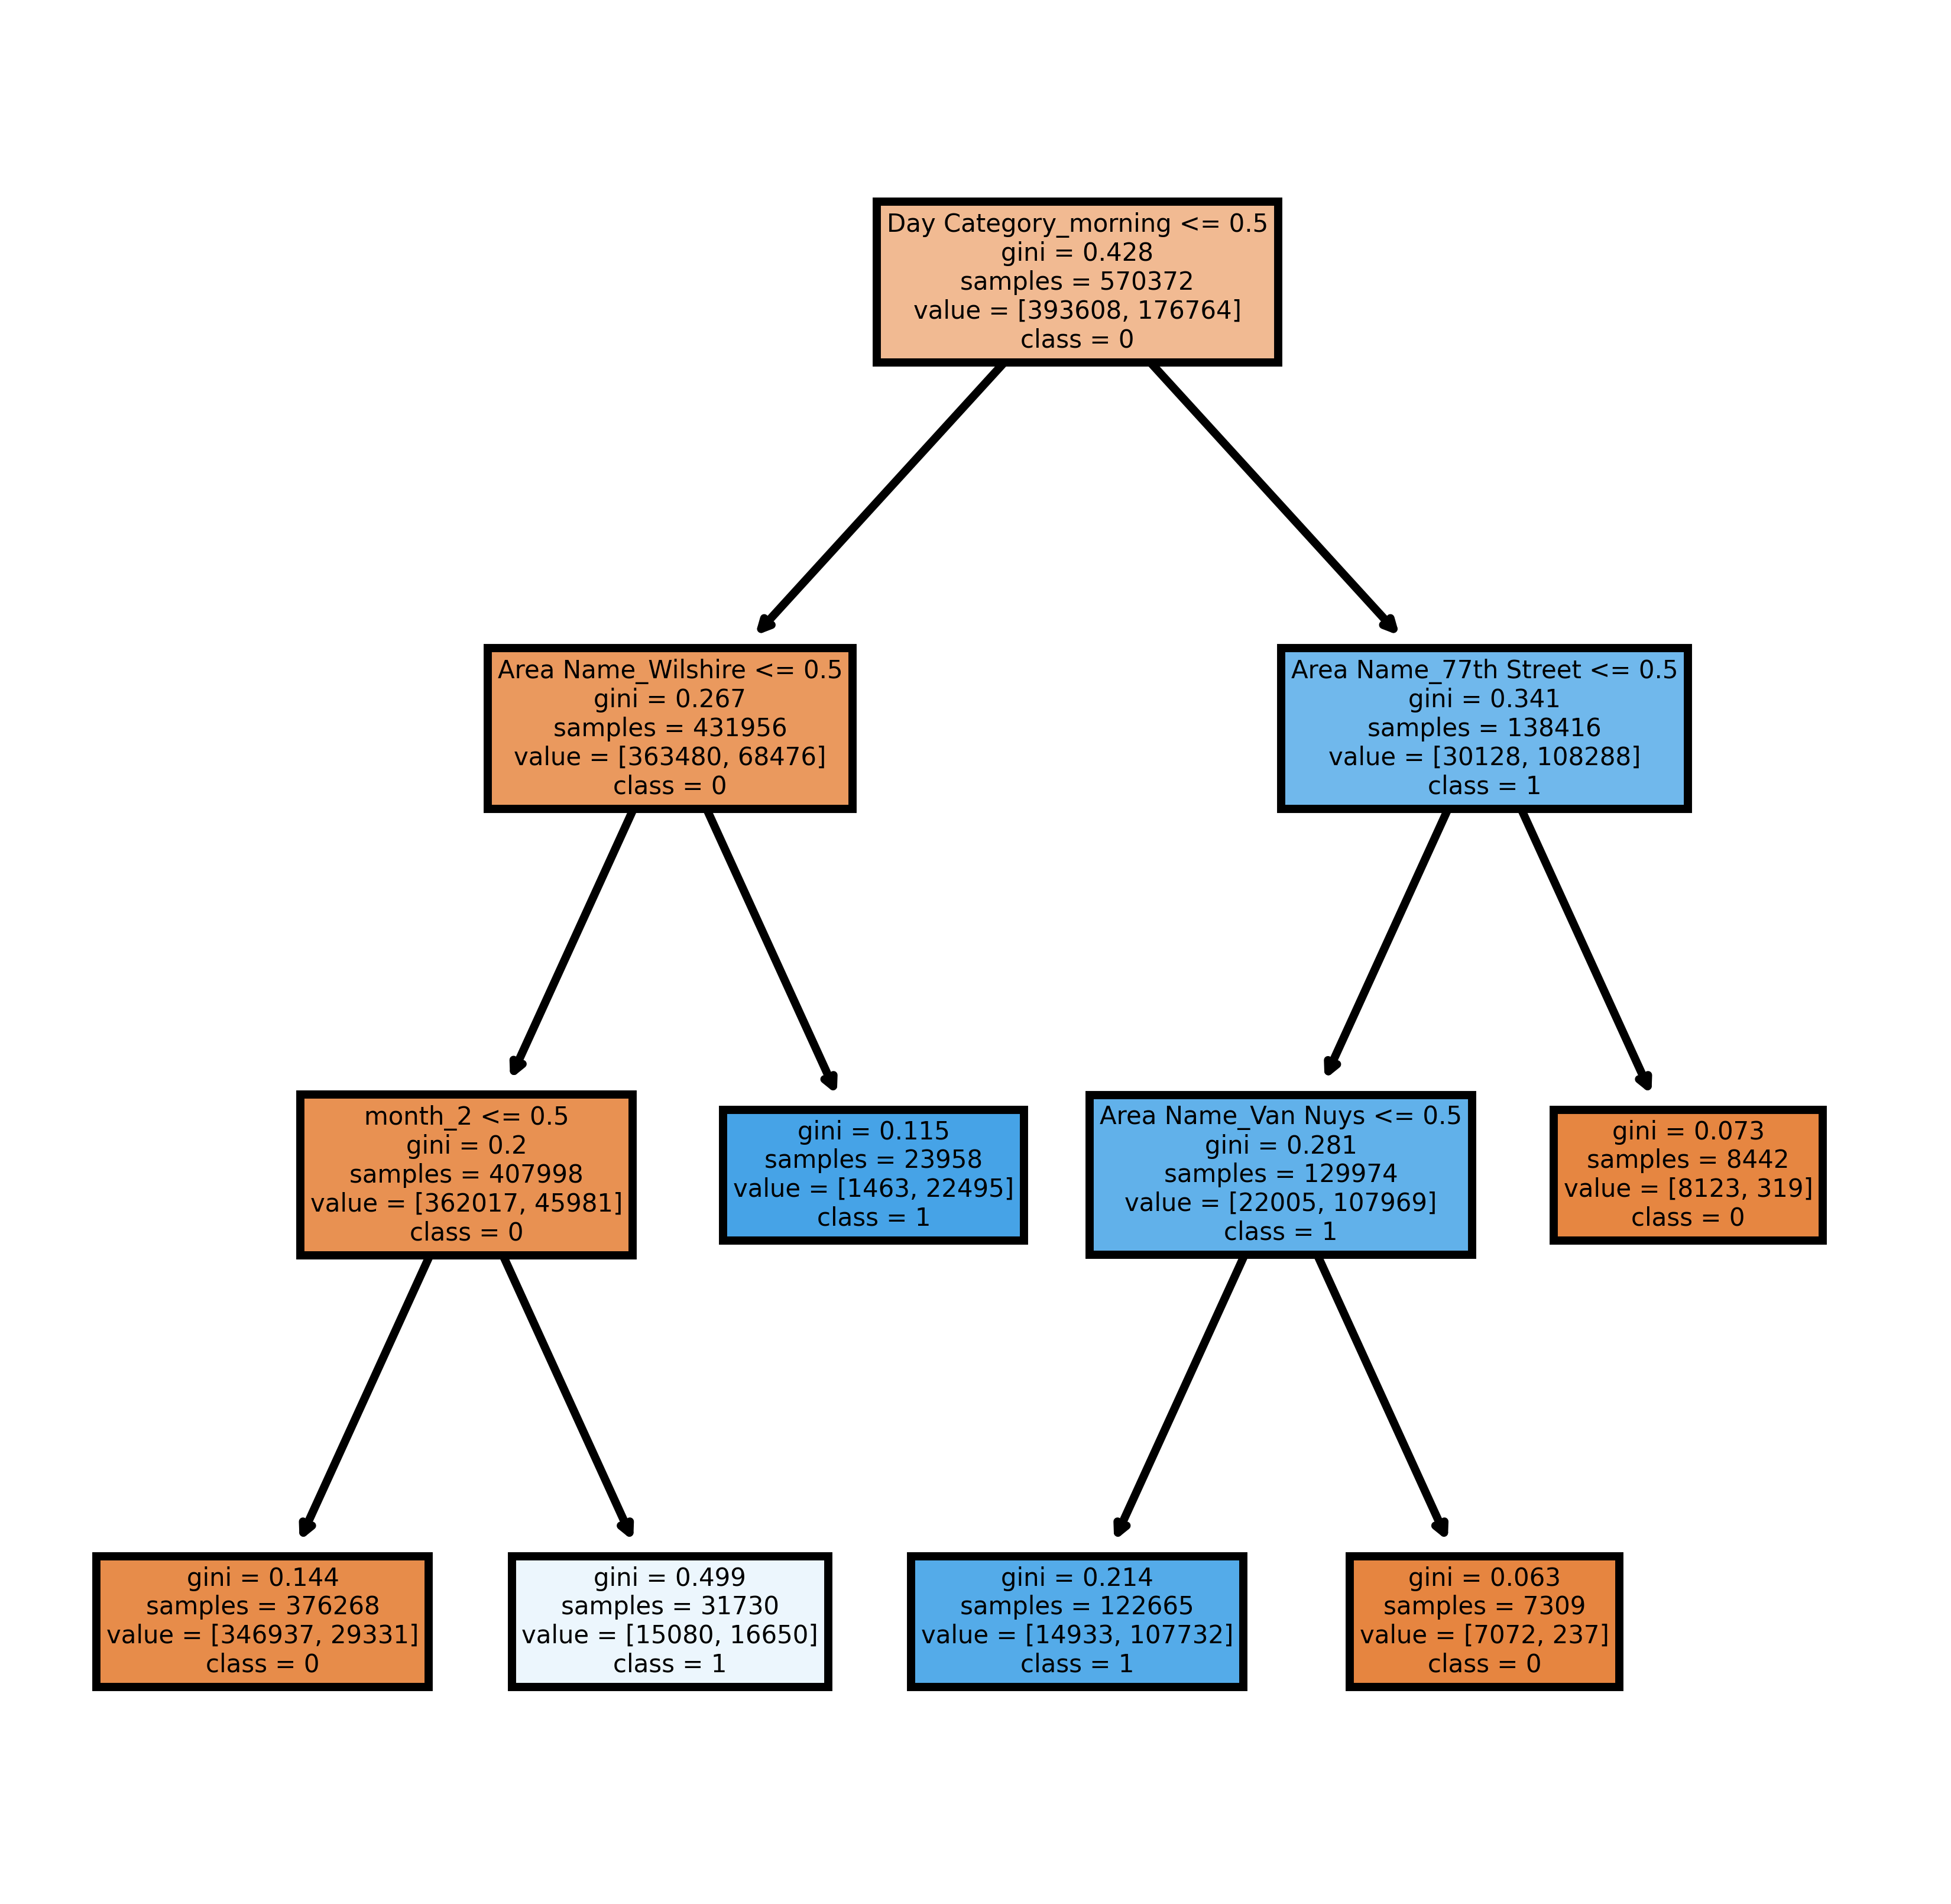

In [84]:
model_1 = parameters_1.best_estimator_ 

plt.figure(figsize=(4,4), dpi=1000)
plot_tree(
    model_1, 
    feature_names=list(X.columns),
    class_names=[str(class_) for class_ in list(model_1.classes_)],
    filled=True
)

<h3>Cluster 2</h3>

In [86]:
parameters_2 = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions= {
        "ccp_alpha":np.arange(0, 0.21, 0.01),
        "min_samples_leaf": np.arange(1,10)
    },
    cv=5
)


parameters_2.fit(X, y_2)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [87]:
print(parameters_2.best_params_)

{'min_samples_leaf': 8, 'ccp_alpha': 0.0}


In [14]:
# Cluster 2 evaluation
cluster_report(2, X, y_2, min_samples_leaf=8, pruning_level=0.01)

[Text(0.5555555555555556, 0.9166666666666666, 'Day Category_afternoon <= 0.5\ngini = 0.432\nsamples = 570372\nvalue = [390086, 180286]\nclass = 0'),
 Text(0.3333333333333333, 0.75, 'Area Name_Van Nuys <= 0.5\ngini = 0.295\nsamples = 436957\nvalue = [358538, 78419]\nclass = 0'),
 Text(0.2222222222222222, 0.5833333333333334, 'lat <= 34.14\ngini = 0.24\nsamples = 415860\nvalue = [357985, 57875]\nclass = 0'),
 Text(0.1111111111111111, 0.4166666666666667, 'gini = 0.11\nsamples = 299353\nvalue = [281928, 17425]\nclass = 0'),
 Text(0.3333333333333333, 0.4166666666666667, 'Day Category_evening <= 0.5\ngini = 0.453\nsamples = 116507\nvalue = [76057, 40450]\nclass = 0'),
 Text(0.2222222222222222, 0.25, 'Day Category_early_morning <= 0.5\ngini = 0.355\nsamples = 86451\nvalue = [66520, 19931]\nclass = 0'),
 Text(0.1111111111111111, 0.08333333333333333, 'gini = 0.208\nsamples = 69743\nvalue = [61530, 8213]\nclass = 0'),
 Text(0.3333333333333333, 0.08333333333333333, 'gini = 0.419\nsamples = 16708\n

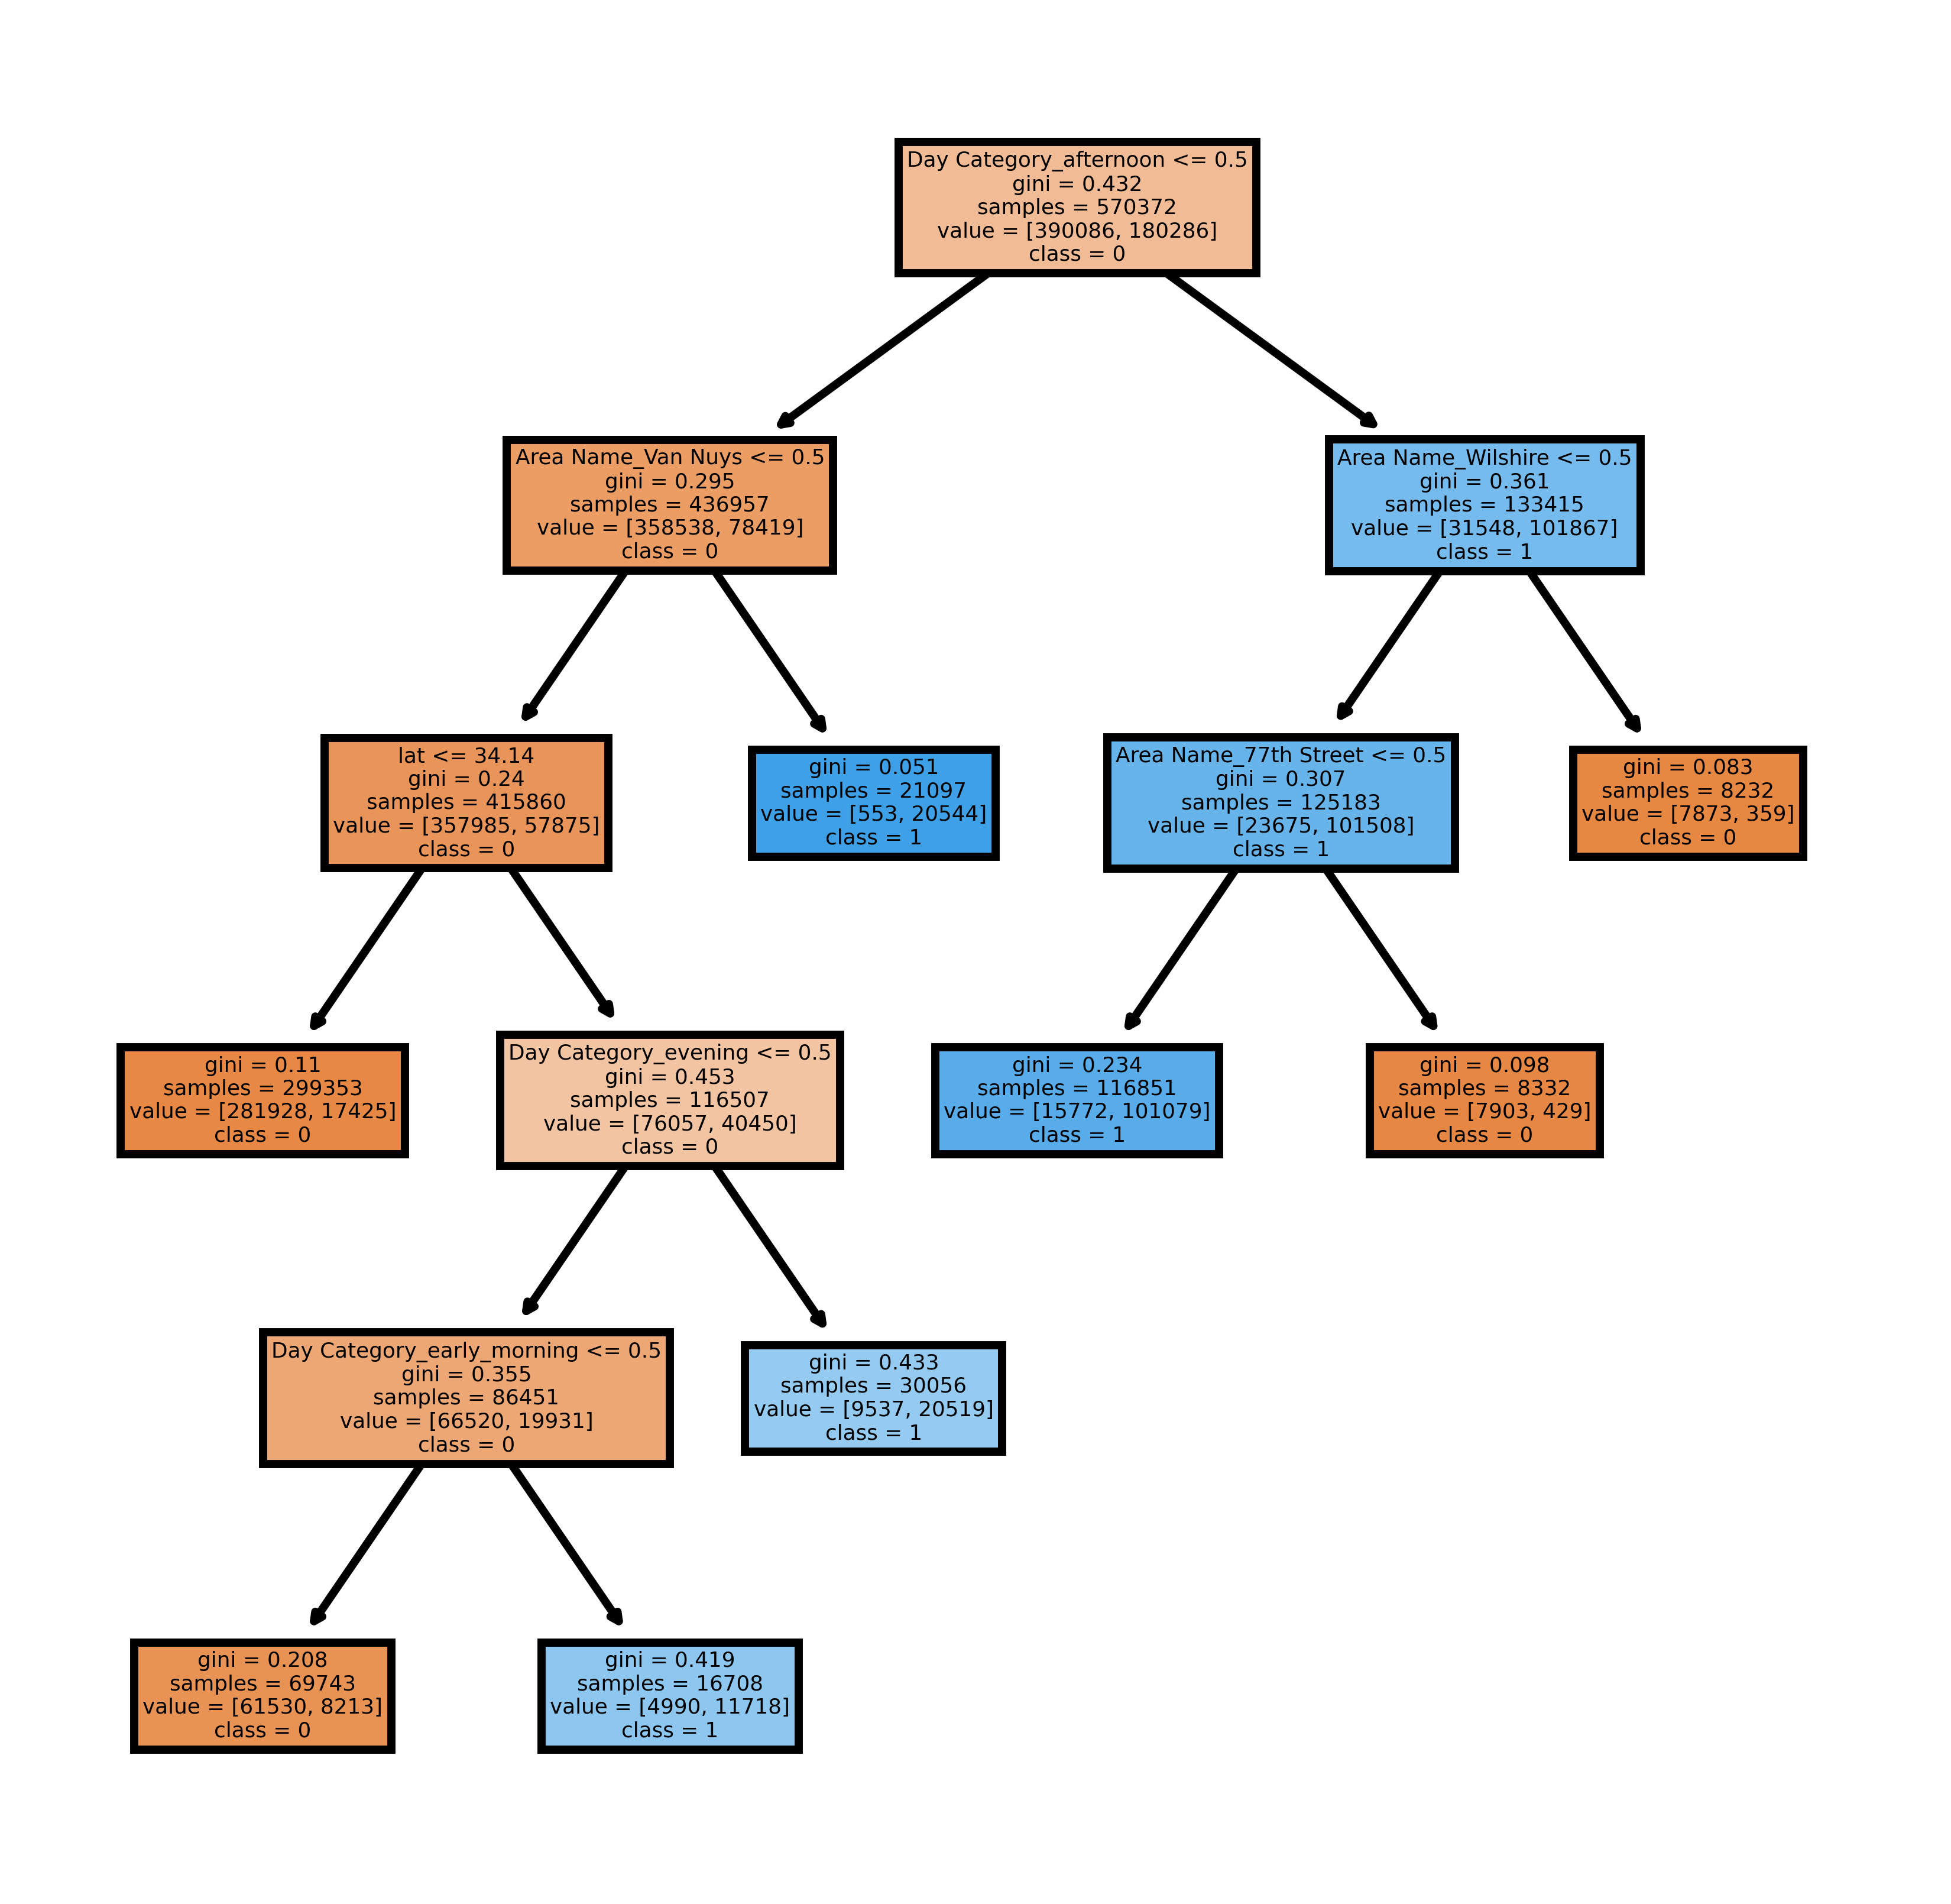

In [11]:
model_2 = DecisionTreeClassifier(min_samples_leaf=8, ccp_alpha=0.01)
model_2.fit(X, y_2)
plt.figure(figsize=(4,4), dpi=1000)
plot_tree(
    model_2, 
    feature_names=list(X.columns),
    class_names=[str(class_) for class_ in list(model_2.classes_)],
    filled=True
)

- feature_category <= 0.5 can be interpreted as 'feature != category'
- feature_category > 0.5 can be interpreted as 'feature = category'

In [4]:
pd.DataFrame(data={
    'Area Name': list(df_unscaled['Area Name'].value_counts().index.values),
    'Collision Rate': df_unscaled['Area Name'].value_counts() / 
})
df_unscaled['Area Name'].value_counts()

77th Street    37914
Southwest      33602
Wilshire       32140
N Hollywood    30026
West LA        29948
Olympic        29854
Pacific        29650
Newton         29220
Van Nuys       28382
Devonshire     27890
West Valley    27572
Hollywood      27517
Northeast      25502
Mission        24972
Southeast      24708
Topanga        24248
Central        23407
Rampart        21508
Harbor         21471
Hollenbeck     20719
Foothill       20122
Name: Area Name, dtype: int64